### Time Series Forecasting. Energy consumption prediction, notebook content 


* Loading the data (PJM Interconnection LLC regional trasmission organization in the united stated providing  )

* Feature Creation 

* Visualizing the time series 

* Feature creation --> No added features for MVP 

* Train/Test split --> simple no cross validation for round 1 
    * Everything prior to 2015 is training data 
    * Everything after 2015 is test data 

* Feature Importance 

* Forcast on test data 

* score (RMSE)

* Calculate Error 

* Next steps 

In [70]:

# Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb 

from sklearn.metrics import mean_squared_error
## Define a color palette
color_palette = sns.color_palette()


### Background Knowledge 

Reference 
https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

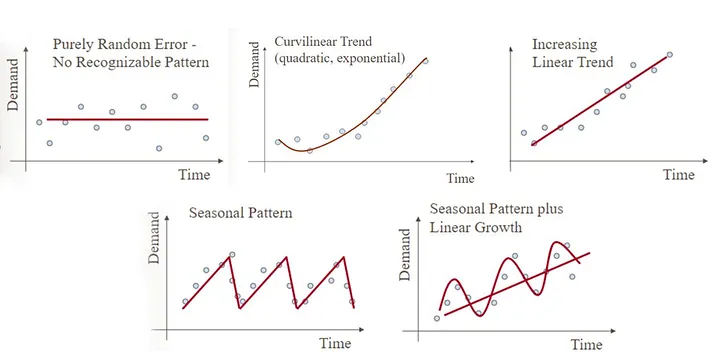


Most signals we analyze exhibit a comination of those patterns and hence can be "modelled" using the function 


Trend, Seasonality, Cyclic, and residual components 


U(t)  = T(t) + S(t) + C(t) + R(t)


In [71]:
## Read the data
df = pd.read_csv('PJME_hourly.csv')


In [72]:
## Quick Exploratory data analysis 
df.head(10)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
5,2002-12-31 06:00:00,26222.0
6,2002-12-31 07:00:00,28702.0
7,2002-12-31 08:00:00,30698.0
8,2002-12-31 09:00:00,31800.0
9,2002-12-31 10:00:00,32359.0


In [73]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [74]:
# Set the date as the index

df = df.set_index('Datetime')
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [75]:
# Check type of index
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [76]:
#Change the index to datetime
df.index = pd.to_datetime(df.index)

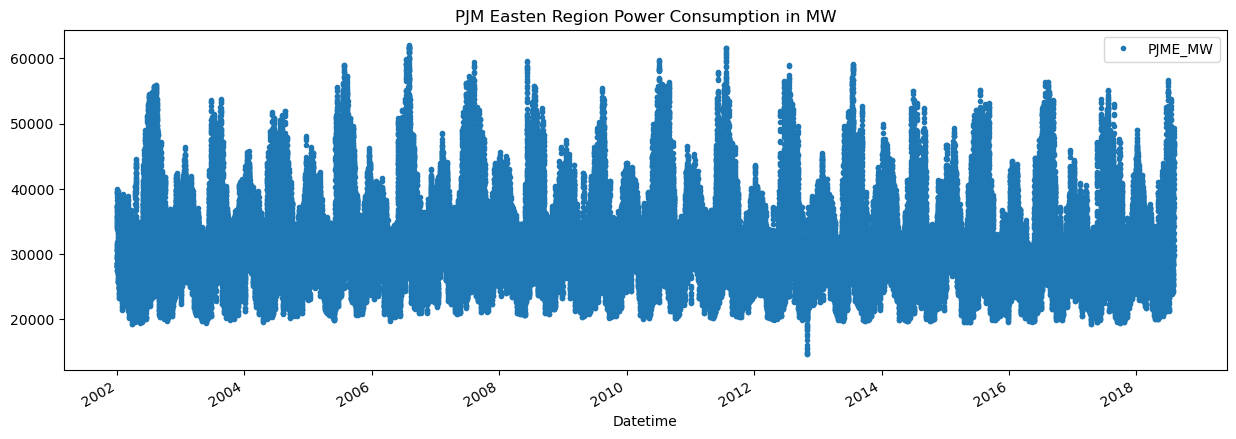

In [77]:
# Visualize the data 


# istantiate the figure
df.plot( style = '.',
         figsize = (15,5), 
         color = color_palette[0], 
         title = 'PJM Easten Region Power Consumption in MW')

# Plot the figure 
plt.show()


### Train/Test split 

* Mvp 
* Model 1 

In [78]:
#Train test split 

# Everthing before 2015 is train data 

training_df = df.loc[df.index < '2015-01-01'] 
testing_df = df.loc[df.index >= '2015-01-01']


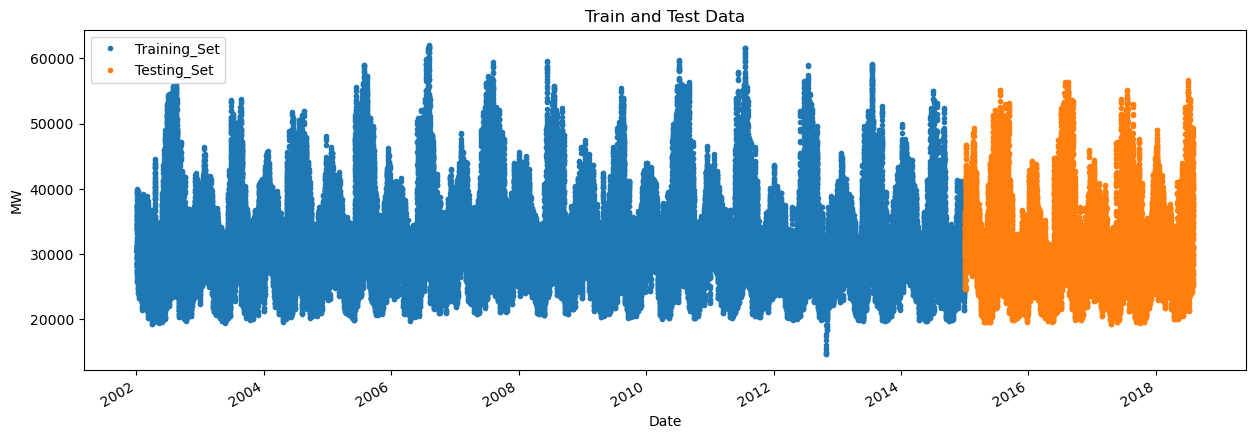

In [79]:
#Visualize the train and test data on the same plot to visulize the split using matplotlib subplots 

#Instantiate the figure
fig,ax = plt.subplots(figsize = (15,5))
training_df.plot(ax = ax, style = '.', label = 'Training_Set', color = color_palette[0])
testing_df.plot(ax = ax, style = '.', label = 'Testing_Set', color = color_palette[1])
ax.set_title('Train and Test Data')
ax.legend(['Training_Set','Testing_Set'])
plt.xlabel('Date')
plt.ylabel('MW')

#Plot the figure
plt.show()





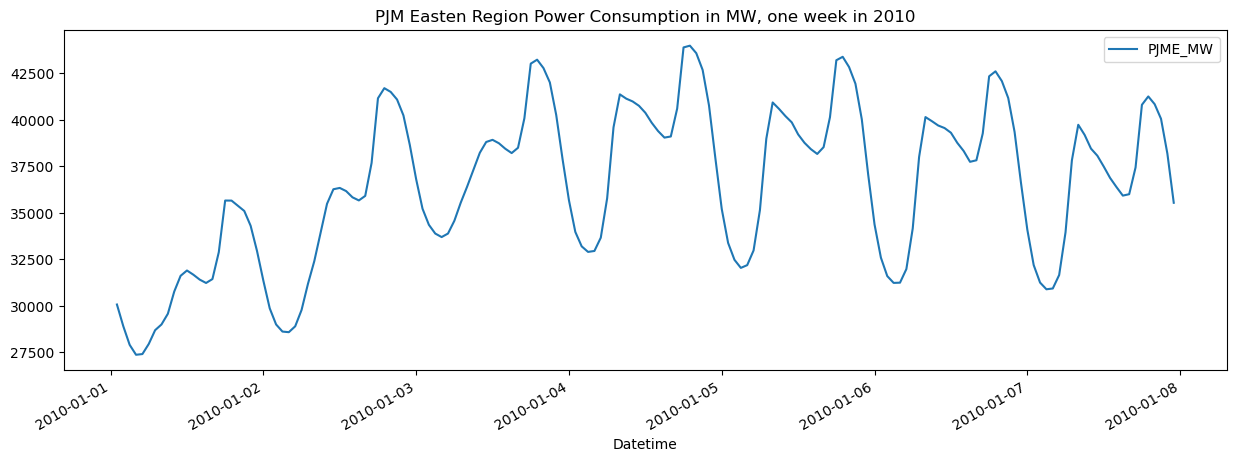

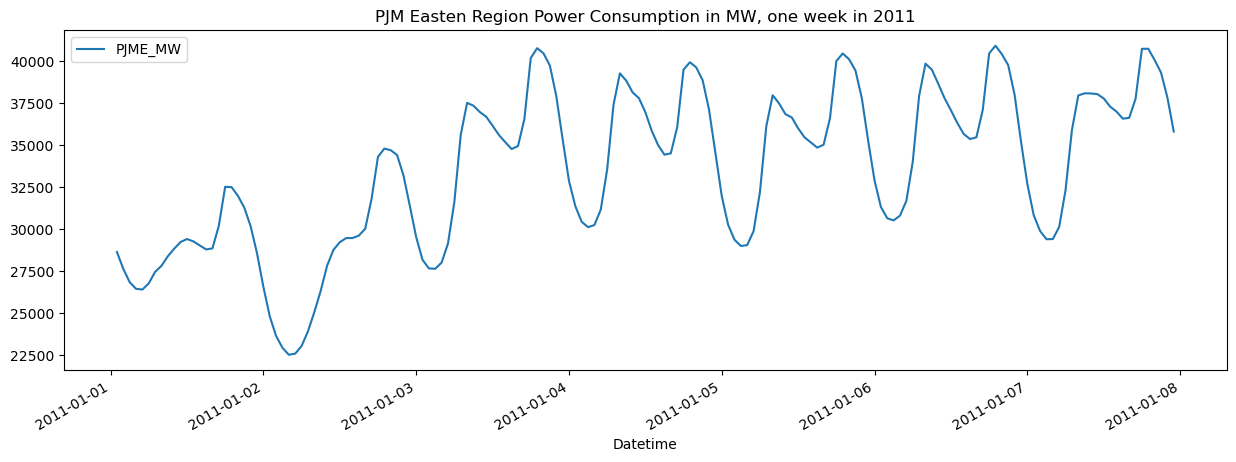

In [80]:
# Drill down on monthy and weekly data 

# January 2010 weekly

df_weekly = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] 
df_weekly.plot(
    
         figsize = (15,5), 
         color = color_palette[0], 
         title = 'PJM Easten Region Power Consumption in MW, one week in 2010')

# Plot the figure 


# January 2011 weekly 

df_weekly = df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')]
df_weekly.plot(
    
         figsize = (15,5), 
         color = color_palette[0], 
         
         title = 'PJM Easten Region Power Consumption in MW, one week in 2011')

plt.show()


One can see from this weekly for 2010 and 2011 show similar behaviour in that it seems first and second of january are holidays and weekends so the overal energy consumption is lower but still varies up and down through the day as expected and as the rest of the week days 

## Feature creation 

Will create a function that takes in a dataframe, creates of few date features and returns this dataframe 

In [81]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [82]:
df = create_features(df)

In [83]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


Text(0.5, 1.0, 'Boxplot of Monthly Power Consumption by Month')

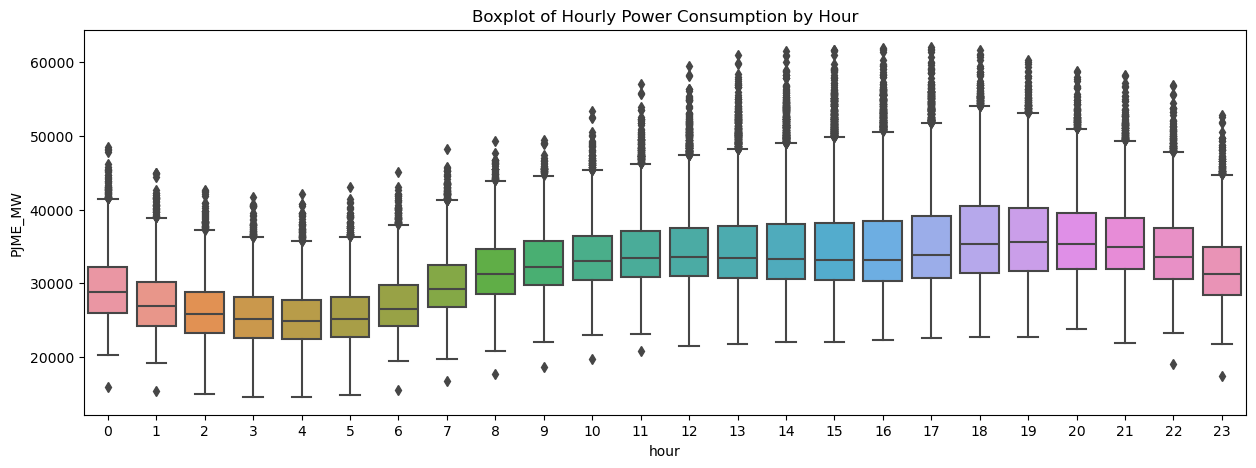

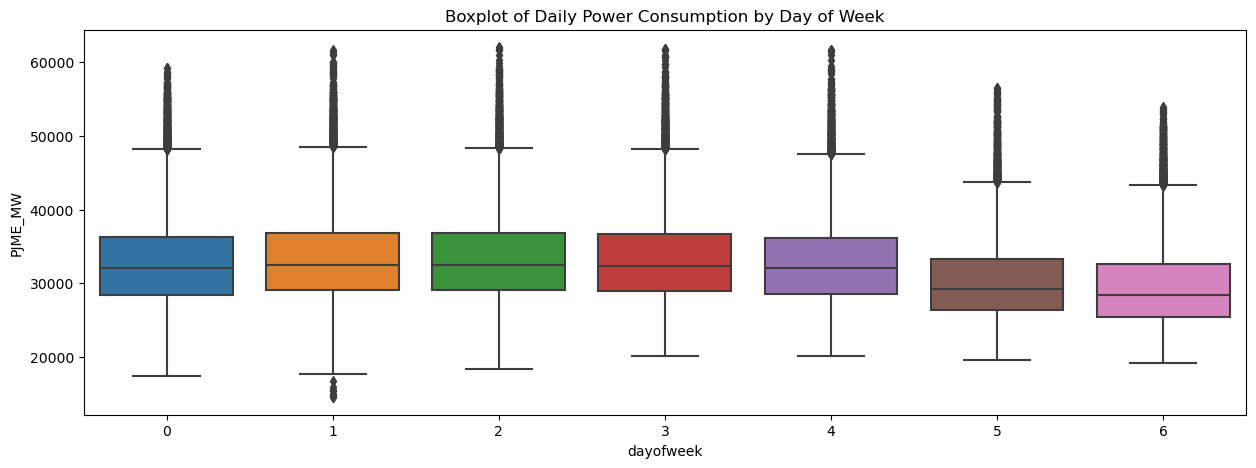

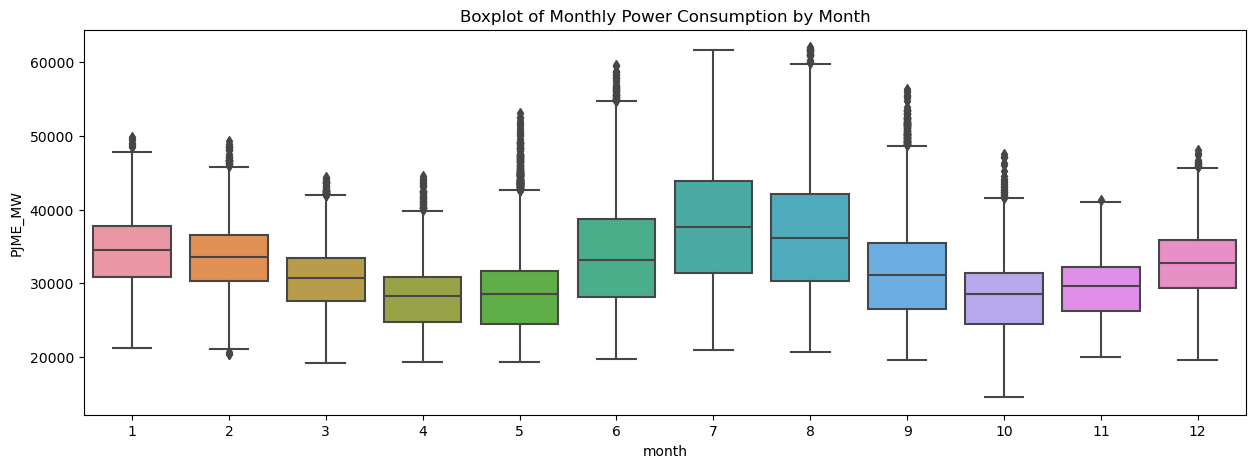

In [84]:
## Visualize feature to target relationship

## Hourly 
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'hour', y = 'PJME_MW')
ax.set_title('Boxplot of Hourly Power Consumption by Hour')

## Daily
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'dayofweek', y = 'PJME_MW')
ax.set_title('Boxplot of Daily Power Consumption by Day of Week')

## Monthly
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(data = df , x = 'month', y = 'PJME_MW')
ax.set_title('Boxplot of Monthly Power Consumption by Month')




## Model 

In [94]:
## Add features to our train and test data

train = create_features(training_df) 
test = create_features(testing_df)


## Define the features and target columns 

features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'PJME_MW'



In [95]:
# Create X and y train

X_train = train[features]
y_train = train[target]

# Create X and y test

X_test = test[features]
y_test = test[target]

In [102]:
## Instantiate the model, fit and predict 
## Use early stopping to prevent overfitting

regression = xgb.XGBRegressor(n_estimators = 1000,  early_stopping_rounds = 50, learning_rate = 0.01)
regression.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 50)




[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[50]	validation_0-rmse:4762.32074	validation_1-rmse:5012.22041
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[150]	validation_0-rmse:3476.74522	validation_1-rmse:4012.03356
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[250]	validation_0-rmse:3096.08350	validation_1-rmse:3778.66977
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[350]	validation_0-rmse:2920.57462	validation_1-rmse:3742.00487
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importances 

In [104]:
# Creating feature importance dataframe

feature_importance = pd.DataFrame(data = regression.feature_importances_, 
             index = regression.feature_names_in_, 
             columns = ['importance'])

In [106]:
feature_importance.head()

,importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824


<Axes: >

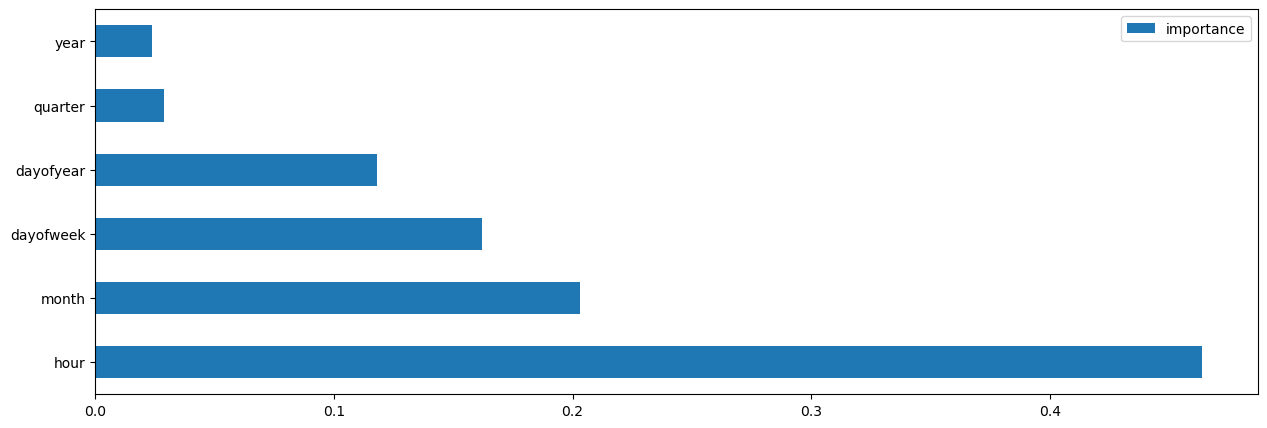

In [105]:
## Visualizing feature importance

feature_importance.sort_values(by = 'importance', ascending = False).plot(kind = 'barh', figsize = (15,5))

In [87]:
## Predict on test data


In [112]:
test['prediction']= regression.predict(X_test)

In [113]:
## Merging the prediction with the raw data
df = df.merge(test[['prediction']],  how='left', left_index=True, right_index=True)
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,41545.953125,41545.953125,41545.953125
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41135.625000,41135.625000,41135.625000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39968.492188,39968.492188,39968.492188


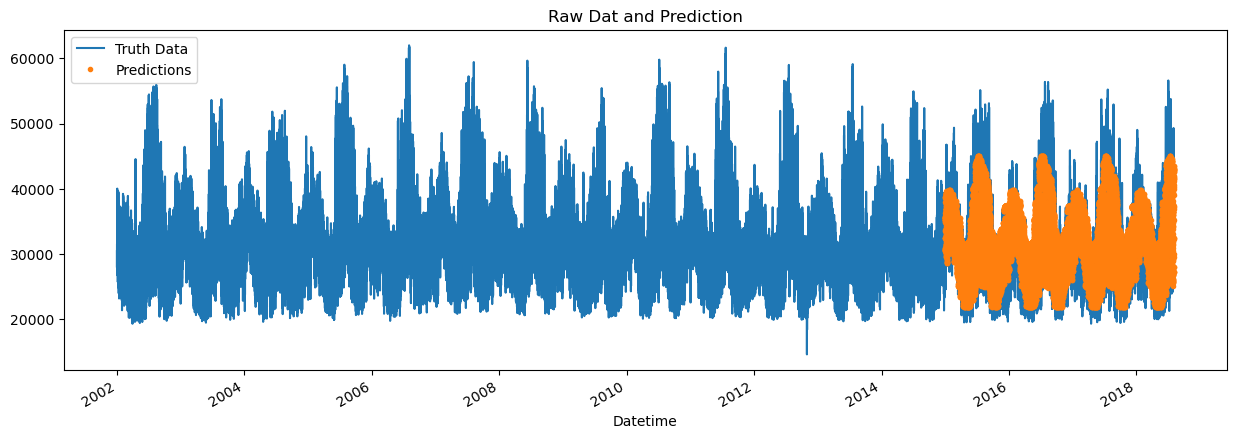

In [114]:
## Visualize the prediction and actual values

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()